In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import time
import gc
import os
import pickle
import sys

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def one_hot_one_level(df, f, k):
    ones = np.ones((train_df.shape[0]))
    return (np.multiply(train_df[f] == k, ones)).astype(np.int8)

def show_xgb_importances(model, score_type='weight', n = 20):
    scores = model.get_score(importance_type=score_type)
    scores = list(zip(scores.keys(), scores.values()))
    scores.sort(key=lambda x: x[1])
    scores = np.array(scores)[-n:]    
    y, x, labels = np.arange(scores.shape[0]), scores[:, 1].astype(float), scores[:, 0]
    _, ax = plt.subplots()
    ax.barh(y, x)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    plt.show()    


In [3]:
nrows=184903891-1
nchunk=25000000
val_size=2500000
frm=nrows-75000000

debug = False
use_lgb = False


if debug:
    frm=0
    nchunk=100000
    val_size=10000
to=frm+nchunk

In [ ]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }

print('loading train data...',frm,to)
train_df = pd.read_csv("../input/train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

print('loading test data...')
if debug:
    test_df = pd.read_csv("../input/test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
else:
    test_df = pd.read_csv("../input/test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

len_train = len(train_df)
train_df=train_df.append(test_df)

del test_df
gc.collect()

loading train data... 109903890 134903890
loading test data...


14

In [ ]:
print('new features')

train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

print("next click")
predictors=[]
train_df['click_time'] = (train_df['click_time'].astype(np.int64) // 10 ** 9).astype(np.int32)
train_df['nextClick'] = (train_df.groupby(['ip', 'app', 'device', 'os']).click_time.shift(-1) \
                         - train_df.click_time).astype(np.float32)
predictors.append('nextClick')
train_df['nextClick_shift'] = train_df['nextClick'].shift(+1).values
predictors.append('nextClick_shift')

########################################################################################################################

print("target encoding")
with open("../dumps/te.pkl", "rb") as f: te = pickle.load(f)
prior = te['prior']
for k in ['ip', 'app', 'device', 'os', 'channel']:
    new_feature = 'te_'+k
    train_df[new_feature] = train_df[k].map(te[k]).fillna(prior)
    predictors.append(new_feature)
del te, prior
gc.collect()

print("oneHot encoding")
with open("../dumps/to_ohe.pkl", "rb") as f: to_ohe = pickle.load(f)
for f in to_ohe:
    for k in to_ohe[f]:
        new_feature = f+'_'+str(k)
        train_df[new_feature] = one_hot_one_level(train_df, f, k)
        predictors.append(new_feature)

########################################################################################################################

train_df.info()

print("vars and data type: ")
train_df.drop(['click_time'], axis=1, inplace=True)
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')
target = 'is_attributed'

if use_lgb: predictors.extend(['app', 'channel', 'device', 'os'])
predictors.extend(['hour', 'day', 
              'ip_tcount', 'ip_tchan_count', 'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              'ip_app_channel_var_day','ip_app_channel_mean_hour',
              'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
print('predictors', predictors)

test_df = train_df[len_train:]
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))
print(train_df.shape, test_df.shape, val_df.shape)

new features
Counting unqiue  channel  by  ['ip'] ...
X0 max value =  130
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  68576
Counting unqiue  hour  by  ['ip', 'day'] ...
X2 max value =  12
Counting unqiue  app  by  ['ip'] ...


In [ ]:
train_df.shape, test_df.shape, val_df.shape

In [ ]:
# # dumping 
# with open("../dumps/lgb/train.pkl", "wb") as f:
#     pickle.dump(obj=train_df, file=f)
# with open("../dumps/lgb/valid.pkl", "wb") as f:
#     pickle.dump(obj=val_df, file=f)    
# with open("../dumps/lgb/test.pkl", "wb") as f:
#     pickle.dump(obj=test_df, file=f)            
# with open("../dumps/lgb/predictors.pkl", "wb") as f:
#     pickle.dump(obj=predictors, file=f)

In [4]:
# load 
with open("../dumps/lgb/train.pkl", "rb") as f:
    train_df = pickle.load(f)
with open("../dumps/lgb/valid.pkl", "rb") as f:
    val_df = pickle.load(f)
with open("../dumps/lgb/predictors.pkl", "rb") as f:
    predictors = pickle.load(f)
    
y_train = train_df['is_attributed']
y_val = val_df['is_attributed']            

In [5]:
def remove_feature(f):
    if f in train_df.columns: train_df.drop([f], axis=1, inplace=True)
    if f in val_df.columns: val_df.drop([f], axis=1, inplace=True)
    if f in predictors: del predictors[predictors.index(f)]

remove_feature('te_ip')
remove_feature('app')
remove_feature('channel')
remove_feature('click_id')
remove_feature('device')
remove_feature('ip')
remove_feature('os')
remove_feature('is_attributed')
set(train_df.columns) == set(predictors) == set(val_df.columns) 

True

In [6]:
# with open('../dumps/te.pkl', 'rb') as f:
#     te = pickle.load(f)
# for f in ['te_app', 'te_device', 'te_os', 'te_channel']:
#     train_df[f].fillna(te['prior'], inplace=True)
#     val_df[f].fillna(te['prior'], inplace=True)

In [7]:
dmtrain = xgb.DMatrix(train_df, y_train, feature_names=predictors, missing=np.nan)
del train_df
gc.collect()

112

In [8]:
dmvalid = xgb.DMatrix(val_df, y_val, feature_names=predictors, missing=np.nan)
del val_df
gc.collect()

0

In [9]:
params = {
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc', 
    'hthread':4,
    'silent': 1,
    'grow_policy': "lossguide",
}

# .9756 with ohe and te
params['eta'] = 0.15
params['max_depth'] = 4
params['max_leaves'] = 300
params['subsample'] = 0.5
params['colsample_bytree'] = 0.95
params['alpha'] = 2.5
params['lambda'] = 2.5
params['gamma'] = 20
params['min_child_weight'] = 20
params['scale_pos_weight'] = 250

# .9752
params = {
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc', 
    'hthread':4,
    'silent': 1,
    'grow_policy': "lossguide",
    'eta': 0.15,
    'max_leaves': 31,  
    'max_depth': 0, 
    'subsample': 0.4, 
    'colsample_bytree': 0.4,
    'alpha': 1,
    'lambda': 1,
    'gamma': 5,
    'min_child_weight': 20,
    'scale_pos_weight': 200,
}

# 
params['eta'] = 0.15
params['max_depth'] = 0
params['max_leaves'] = 15
params['subsample'] = 0.65
params['colsample_bytree'] = 0.8
params['alpha'] = 0
params['lambda'] = 0
params['gamma'] = 1
params['min_child_weight'] = 0
params['scale_pos_weight'] = 100


In [10]:
# Training process
watchlist = [(dmtrain, 'train'), (dmvalid, 'valid')]
model = xgb.train(params, dmtrain, 100, watchlist, maximize=True, early_stopping_rounds=15, verbose_eval=5)

[0]	train-auc:0.9594	valid-auc:0.942538
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 15 rounds.
[5]	train-auc:0.967886	valid-auc:0.953228
[10]	train-auc:0.97272	valid-auc:0.96698
[15]	train-auc:0.976732	valid-auc:0.967229
[20]	train-auc:0.977188	valid-auc:0.967478
[25]	train-auc:0.979881	valid-auc:0.969468
[30]	train-auc:0.981435	valid-auc:0.970486
[35]	train-auc:0.982802	valid-auc:0.971067
[40]	train-auc:0.983778	valid-auc:0.971141
[45]	train-auc:0.984497	valid-auc:0.971511
[50]	train-auc:0.984952	valid-auc:0.971392
[55]	train-auc:0.985338	valid-auc:0.971423
[60]	train-auc:0.985573	valid-auc:0.97157
[65]	train-auc:0.985812	valid-auc:0.971712
[70]	train-auc:0.986015	valid-auc:0.971797
[75]	train-auc:0.986226	valid-auc:0.971766
[80]	train-auc:0.986471	valid-auc:0.971825
[85]	train-auc:0.986659	valid-auc:0.971769
[90]	train-auc:0.98683	valid-auc:0.971905
[95]	train-auc:0.987005	valid-auc:0.971962
[100]

In [16]:
with open("../dumps/lgb/model.pkl", "wb") as f:
    pickle.dump(model, f)
    
del dmtrain, dmvalid
gc.collect()

In [24]:
# TODO:
# other val sample
# hyperopt tuning
# memory => more data 
# lightgbm: best practice + best parameters from kernel: https://www.kaggle.com/cgundlach/lgbm-single-model-lb-9791/code
# learn feather data format 

Predict

In [30]:
with open("../dumps/lgb/model.pkl", "rb") as f:
    model = pickle.load(f)
    
print("load test")
with open("../dumps/lgb/test.pkl", "rb") as f:
    test_df = pickle.load(f)  
    
def remove_feature_test(f):
    if f in test_df.columns: test_df.drop([f], axis=1, inplace=True)
    if f in predictors: del predictors[predictors.index(f)]
   
with open('../dumps/te.pkl', 'rb') as f:
    te = pickle.load(f)
for f in ['te_app', 'te_device', 'te_os', 'te_channel']:
    test_df[f].fillna(te['prior'], inplace=True)   
        
with open("../dumps/lgb/predictors.pkl", "rb") as f:
    predictors = pickle.load(f)        
        
print("remove features")
for f in ['te_ip', 'app', 'channel', 'click_id', 'device', 'ip', 'os', 'is_attributed']:
    remove_feature_test(f)
    
set(predictors) == set(test_df)

load test
remove features


True

In [31]:
dmtest = xgb.DMatrix(test_df, feature_names=predictors, missing=np.nan)
del test_df
gc.collect()
print("make prediction")
pred = model.predict(dmtest)

make prediction


In [32]:
sample = pd.read_csv('../input/sample_submission.csv')
sample['is_attributed'] = pred
print(sample.isnull().sum())

save submission
click_id         0
is_attributed    0
dtype: int64


In [33]:
print("save submission")
del pred
gc.collect()
sample.to_csv('../sub/xgb_v5_depth0_15levaves.csv.gz', compression='gzip', index=False)
del dmtest
gc.collect()

0

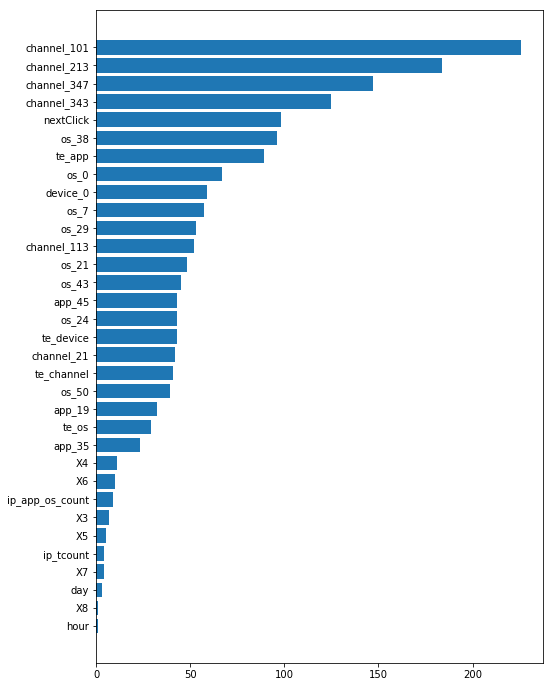

In [29]:
def show_xgb_importances(model, score_type='weight', n = 20):
    scores = model.get_score(importance_type=score_type)
    scores = list(zip(scores.keys(), scores.values()))
    scores.sort(key=lambda x: x[1])
    scores = np.array(scores)[-n:]    
    y, x, labels = np.arange(scores.shape[0]), scores[:, 1].astype(float), scores[:, 0]
    _, ax = plt.subplots()
    ax.barh(y, x)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    plt.show() 

plt.rcParams['figure.figsize']=(8,12)
show_xgb_importances(model, n=50)